In [461]:
# Imports as always...

import pandas as pd
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import skew, norm
from sklearn.preprocessing import RobustScaler
import sklearn.model_selection as ms
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor 
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn import linear_model

import create_data

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Data Preprocessing

In [434]:
# Create master data for Edinburgh (if not created already).
if not Path('datasets/master_edinburgh.csv').is_file():
    create_data.city_data_generation('edinburgh', 'datasets', datetime(2022, 12, 16))
    print('Master data file generated.')

else:
    print('Pre-existing master data file found (no new data created).')

# Note: This takes around 3 minutes on my laptop for ~7800 listings and ~500000 reviews (Edinburgh).

Pre-existing master data file found (no new data created).


In [435]:
# Get the master data.
master_data = pd.read_csv('datasets/master_edinburgh.csv').iloc[:,2:]
master_data

,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,...,neighborhood_overview_polarity,neighborhood_overview_subjectivity,neighborhood_overview_keywords,host_about_polarity,host_about_subjectivity,host_about_keywords,log_price,rental_probability,weighted_average_sentiment,success_score
0,15420,60423,2009-12-06,within a few hours,100%,96%,t,NaN,3,6,...,0.289394,0.471591,"[['own'], ['lovely'], ['more'], ['new'], ['his...",-0.050000,0.850000,[['passionate']],4.736198,0.833333,0.416151,1.642478
1,707097,3092851,2012-07-29,within a day,50%,84%,f,Old Town,9,16,...,0.500000,0.650000,"[['perfect'], ['short']]",0.700000,0.550000,"[['best'], ['comfortable']]",6.393591,1.000000,0.221078,1.413482
2,728199,3776412,2012-10-06,within an hour,100%,95%,t,NaN,1,2,...,0.415789,0.568421,"[['excellent'], ['excellent', '!'], ['great'],...",0.539323,0.625000,"[['perfectly', '!'], ['excellent'], ['great'],...",4.094345,0.257230,0.378266,0.398385
3,732008,3810279,2012-10-09,within an hour,100%,99%,f,Haymarket,6,9,...,NaN,NaN,NaN,0.000000,0.000000,NaN,5.087596,0.446347,0.442620,1.005116
4,744710,3737047,2012-10-02,within an hour,100%,100%,t,New Town,1,1,...,0.275000,0.466667,"[['many'], ['very', 'peaceful'], ['central']]",0.422727,0.613258,"[['great'], ['own'], ['able'], ['love'], ['new']]",4.927254,0.053272,0.421208,0.110562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7384,362653,1775021,2012-02-19,within a few hours,100%,100%,f,Cannonmills,6,7,...,NaN,NaN,NaN,0.450000,0.601852,"[['happy'], ['welcome'], ['own'], ['own'], ['m...",4.553877,0.000000,0.332089,0.000000
7385,363642,1837147,2012-03-01,within an hour,100%,25%,f,NaN,1,2,...,0.216111,0.544444,"[['very', 'easy'], ['free'], ['quick'], ['gree...",0.342700,0.617080,"[['delicious'], ['own'], ['own'], ['love'], ['...",3.688879,0.000000,0.394785,0.000000
7386,376937,1775021,2012-02-19,within a few hours,100%,100%,f,Cannonmills,6,7,...,NaN,NaN,NaN,0.450000,0.601852,"[['happy'], ['welcome'], ['own'], ['own'], ['m...",4.442651,0.000000,0.341248,0.000000
7387,388297,1942840,2012-03-17,within an hour,100%,97%,f,Leith,3,4,...,NaN,NaN,NaN,0.241604,0.464815,"[['best'], ['great'], ['love'], ['enjoy', '!']...",5.442418,0.093607,0.491528,0.250409


In [436]:
# We will be predicting success
# So, it would only be fair for us to remove all data used to generate success scores.
master_data.drop(columns=[
    'price',
    'minimum_nights_avg_ntm', 
    'number_of_reviews_ltm',
    'log_price', 
    'rental_probability',
    'weighted_average_sentiment'
], inplace=True, axis=1)

In [437]:
# Count the number of missing values in each feature.
missing_values = master_data.isna().sum().sort_values(ascending=False)
missing_values

bathrooms                       7389
neighbourhood_group_cleansed    7389
license                         7374
host_neighbourhood              4382
host_about_keywords             3344
                                ... 
host_id                            0
availability_60                    0
availability_90                    0
availability_365                   0
availability_30                    0
Length: 69, dtype: int64

In [438]:
# Drop features with majority missing values.
threshold = master_data.shape[0] // 2
master_data.drop(columns=missing_values[missing_values > threshold].index, inplace=True, axis=1)

In [439]:
# Drop rows with missing a succuess score.
master_data = master_data[master_data.success_score.notna()]

In [440]:
# Remove unhelpful features (for prediction of success).
master_data.drop(columns=[
    'id',
    'host_id',
    'neighbourhood',
    'neighbourhood_cleansed',
    'latitude',
    'longitude',
    'property_type',
    'bathrooms_text',
    'amenities',
    'minimum_minimum_nights', 
    'maximum_minimum_nights',
    'minimum_maximum_nights', 
    'maximum_maximum_nights',
    'maximum_nights_avg_ntm',
    'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms',
    'title_keywords',
    'description_keywords', 
    'neighborhood_overview_keywords',
    'host_about_keywords'
], inplace=True, axis=1) 

# Remove features that almost certinaly don't add anything (e.g. almost all the same value).
master_data.drop(columns=[
    'has_availability',
    'host_has_profile_pic'
])

C:\Users\bwpri\AppData\Local\Temp\ipykernel_10036\3091637929.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_data.drop(columns=[


,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified,room_type,...,reviews_per_month,title_polarity,title_subjectivity,description_polarity,description_subjectivity,neighborhood_overview_polarity,neighborhood_overview_subjectivity,host_about_polarity,host_about_subjectivity,success_score
0,2009-12-06,within a few hours,100%,96%,t,3,6,"['email', 'phone']",t,Entire home/apt,...,3.10,0.600000,1.000000,0.301429,0.592759,0.289394,0.471591,-0.050000,0.850000,1.642478
1,2012-07-29,within a day,50%,84%,f,9,16,"['email', 'phone']",t,Entire home/apt,...,0.55,0.000000,0.000000,NaN,NaN,0.500000,0.650000,0.700000,0.550000,1.413482
2,2012-10-06,within an hour,100%,95%,t,1,2,"['email', 'phone']",t,Private room,...,2.86,-0.008333,0.250000,0.308384,0.471296,0.415789,0.568421,0.539323,0.625000,0.398385
3,2012-10-09,within an hour,100%,99%,f,6,9,"['email', 'phone']",t,Entire home/apt,...,2.27,0.000000,0.000000,0.329877,0.625805,NaN,NaN,0.000000,0.000000,1.005116
4,2012-10-02,within an hour,100%,100%,t,1,1,"['email', 'phone']",t,Entire home/apt,...,1.73,0.055682,0.289773,0.573485,0.767172,0.275000,0.466667,0.422727,0.613258,0.110562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7384,2012-02-19,within a few hours,100%,100%,f,6,7,"['email', 'phone']",t,Private room,...,0.33,0.000000,0.000000,0.046667,0.280000,NaN,NaN,0.450000,0.601852,0.000000
7385,2012-03-01,within an hour,100%,25%,f,1,2,"['email', 'phone']",t,Private room,...,0.54,0.000000,0.000000,0.300778,0.475556,0.216111,0.544444,0.342700,0.617080,0.000000
7386,2012-02-19,within a few hours,100%,100%,f,6,7,"['email', 'phone']",t,Entire home/apt,...,0.63,0.000000,0.000000,0.164586,0.418837,NaN,NaN,0.450000,0.601852,0.000000
7387,2012-03-17,within an hour,100%,97%,f,3,4,"['email', 'phone']",t,Entire home/apt,...,0.74,0.625000,1.000000,0.253704,0.726157,NaN,NaN,0.241604,0.464815,0.250409


In [441]:
# Helper function for converting dates to days since.
def elapsed_days(from_date_as_string, to_date=datetime(2022, 12, 16)):
    from_date = datetime.strptime(from_date_as_string, '%Y-%m-%d')
    return max(0, (to_date - from_date).days)

In [442]:
# Convert pseudonumeric types (e.g. dates) to numeric...

master_data.host_since = master_data.host_since.apply(elapsed_days)

master_data.host_response_rate = master_data.host_response_rate.apply(
    lambda x : float(x[:-1]) if not pd.isna(x) 
    else x
)

master_data.host_acceptance_rate = master_data.host_acceptance_rate.apply(
    lambda x : float(x[:-1]) if not pd.isna(x) 
    else x
)

master_data.host_verifications = master_data.host_verifications.apply(
    lambda x : len(x)
)

master_data.first_review = master_data.first_review.apply(
    lambda x : elapsed_days(x) if not pd.isna(x)
    else x
)

master_data.last_review = master_data.last_review.apply(
    lambda x : elapsed_days(x) if not pd.isna(x)
    else x
)

C:\Users\bwpri\AppData\Local\Temp\ipykernel_10036\2791973381.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_data.host_since = master_data.host_since.apply(elapsed_days)
C:\Users\bwpri\AppData\Local\Temp\ipykernel_10036\2791973381.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_data.host_response_rate = master_data.host_response_rate.apply(
C:\Users\bwpri\AppData\Local\Temp\ipykernel_10036\2791973381.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [443]:
# Another look at missing data.
master_data.isna().sum().sort_values(ascending=False)

host_about_subjectivity               2678
host_about_polarity                   2678
neighborhood_overview_subjectivity    1823
neighborhood_overview_polarity        1823
host_response_time                    1313
host_response_rate                    1313
host_acceptance_rate                   591
bedrooms                               103
beds                                    59
description_subjectivity                52
description_polarity                    52
review_scores_accuracy                  13
review_scores_cleanliness               13
review_scores_location                  13
review_scores_checkin                   13
review_scores_communication             13
review_scores_value                     13
host_since                               0
instant_bookable                         0
reviews_per_month                        0
last_review                              0
title_polarity                           0
title_subjectivity                       0
review_scor

In [444]:
# Replace missing polarity and subjectivity scores with 0 (i.e. neutral and factual).
master_data.host_about_polarity = master_data.host_about_polarity.fillna(0)
master_data.host_about_subjectivity = master_data.host_about_subjectivity.fillna(0)
master_data.neighborhood_overview_polarity = master_data.neighborhood_overview_polarity.fillna(0)
master_data.neighborhood_overview_subjectivity = master_data.neighborhood_overview_subjectivity.fillna(0)
master_data.description_polarity = master_data.description_polarity.fillna(0)
master_data.description_subjectivity = master_data.description_subjectivity.fillna(0)

# Replace missing host_response_rate and host_acceptance_rate with mean values.
master_data.host_response_rate = master_data.host_response_rate.fillna(master_data.host_response_rate.mean())
master_data.host_acceptance_rate = master_data.host_acceptance_rate.fillna(master_data.host_acceptance_rate.mean()) 

C:\Users\bwpri\AppData\Local\Temp\ipykernel_10036\4173031145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_data.host_about_polarity = master_data.host_about_polarity.fillna(0)
C:\Users\bwpri\AppData\Local\Temp\ipykernel_10036\4173031145.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_data.host_about_subjectivity = master_data.host_about_subjectivity.fillna(0)
C:\Users\bwpri\AppData\Local\Temp\ipykernel_10036\4173031145.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

In [445]:
# Remove all rows with missing values still remaining.
master_data = master_data.dropna()

In [446]:
# Calculate the skewness of the features.
skewness = master_data.skew().sort_values(ascending=False)
skewness[abs(skewness) > 1]

# Don't worry about skewness with the success scores.
skewness.success_score = 0

C:\Users\bwpri\AppData\Local\Temp\ipykernel_10036\868433799.py:2: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  skewness = master_data.skew().sort_values(ascending=False)


minimum_nights                 47.234752
host_total_listings_count      16.017784
host_listings_count            14.326182
last_review                     5.408654
beds                            4.361324
number_of_reviews_l30d          2.767483
number_of_reviews               2.481016
bedrooms                        1.826222
accommodates                    1.648957
reviews_per_month               1.624699
success_score                   1.592931
host_verifications              1.088369
title_polarity                  1.001872
host_acceptance_rate           -3.451843
review_scores_cleanliness      -4.497765
review_scores_value            -4.697238
review_scores_rating           -4.900070
review_scores_location         -5.726568
host_response_rate             -6.091119
review_scores_checkin          -6.197279
review_scores_accuracy         -6.253728
review_scores_communication    -6.528354
dtype: float64

In [447]:
# Deal with positive skewness by performing a square root transformation.
for skew_feature in skewness[skewness > 1.5].index:
    master_data[skew_feature] = np.power(master_data[skew_feature], 1/2)

# Deal with negative skewness by performing a square transformation.
for skew_feature in skewness[skewness < -1.5].index:
    master_data[skew_feature] = np.power(master_data[skew_feature], 2)

In [448]:
# Re-assess skewness.
skewness = master_data.skew().sort_values(ascending=False)
skewness[abs(skewness) > 1]

# Don't worry about skewness with the success scores.
skewness.success_score = 0

C:\Users\bwpri\AppData\Local\Temp\ipykernel_10036\3175040832.py:2: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  skewness = master_data.skew().sort_values(ascending=False)


minimum_nights                 14.693917
host_total_listings_count       6.674743
host_listings_count             6.142976
last_review                     3.144335
success_score                   1.592931
beds                            1.584147
bedrooms                        1.141243
host_verifications              1.088369
number_of_reviews               1.048344
title_polarity                  1.001872
host_acceptance_rate           -2.323070
review_scores_cleanliness      -2.750887
review_scores_value            -2.821942
review_scores_rating           -2.947502
review_scores_location         -3.276227
review_scores_accuracy         -4.073730
review_scores_checkin          -4.113032
review_scores_communication    -4.163754
host_response_rate             -4.378314
dtype: float64

In [449]:
# Deal with positive skewness AGAIN by performing a square root transformation AGAIN (i.e. fourth root).
for skew_feature in skewness[skewness > 1.5].index:
    master_data[skew_feature] = np.power(master_data[skew_feature], 1/2)

# Deal with negative skewness AGAIN by performing a square transformation AGAIN (i.e. to power 4).
for skew_feature in skewness[skewness < -1.5].index:
    master_data[skew_feature] = np.power(master_data[skew_feature], 2)

In [450]:
# Re-assess skewness.
skewness = master_data.skew().sort_values(ascending=False)
skewness[abs(skewness) > 1]

# Don't worry about skewness with the success scores.
skewness.success_score = 0

C:\Users\bwpri\AppData\Local\Temp\ipykernel_10036\3175040832.py:2: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  skewness = master_data.skew().sort_values(ascending=False)


minimum_nights                 5.247944
host_total_listings_count      3.074534
host_listings_count            2.845476
last_review                    1.742818
success_score                  1.592931
bedrooms                       1.141243
host_verifications             1.088369
number_of_reviews              1.048344
title_polarity                 1.001872
beds                           1.001155
review_scores_value           -1.482781
host_acceptance_rate          -1.617207
review_scores_cleanliness     -1.625824
review_scores_rating          -1.646643
review_scores_location        -1.913305
review_scores_accuracy        -2.460261
review_scores_communication   -2.613820
review_scores_checkin         -2.672716
host_response_rate            -3.278557
dtype: float64

In [451]:
# Normalise.
# master_data = (master_data - master_data.mean()) / master_data.std()

In [452]:
# Convert categorical (e.g. boolean) types to numeric...

master_data.host_response_time = master_data.host_response_time.map(
    lambda x : {'within an hour' : 1, 'within a few hours' : 2, 'within a day' : 3, 'a few days or more' : 4}.get(x, 0)
)

master_data.host_is_superhost = master_data.host_is_superhost.map(
    lambda x : {'t' : 1, 'f' : 0}.get(x, 0)
)

master_data.host_has_profile_pic = master_data.host_has_profile_pic.map(
    lambda x : {'t' : 1, 'f' : 0}.get(x, 0)
)

master_data.host_identity_verified = master_data.host_identity_verified.map(
    lambda x : {'t' : 1, 'f' : 0}.get(x, 0)
)

master_data.room_type = master_data.room_type.map(
    lambda x : {'Entire home/apt' : 1, 'Private room' : 2, 'Hotel room' : 3, 'Shared room' : 4}.get(x, 0)
)

master_data.has_availability = master_data.has_availability.map(
    lambda x : {'t' : 1, 'f' : 0}.get(x, 0)
)

master_data.instant_bookable = master_data.instant_bookable.map(
    lambda x : {'t' : 1, 'f' : 0}.get(x, 0)
)

<AxesSubplot: >

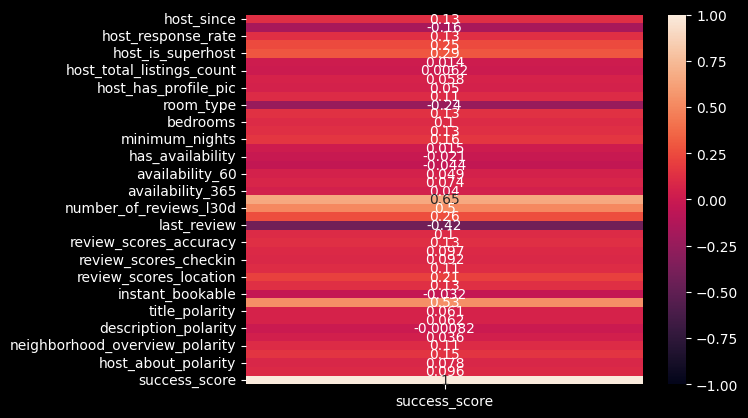

In [453]:
# Show the correlations with success.
corr = master_data.corr()[['success_score']]
sns.heatmap(corr, annot=True, vmin=-1, vmax=1)

<AxesSubplot: >

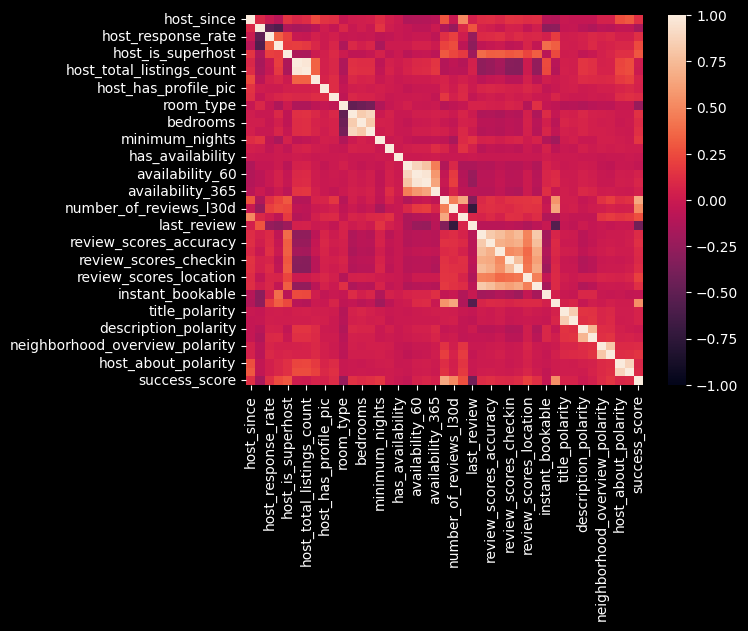

In [454]:
# Show the pairwise correlations across the entire data.
sns.heatmap(master_data.corr(), vmin=-1, vmax=1)

# Building a 'full' model

In [455]:
# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    master_data.drop('success_score', axis=1), master_data['success_score'], test_size=0.2, shuffle=True, random_state=123
)

In [457]:
# Instatiate and fit a linear regressor.
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [463]:
# Predict with the model.
y_pred = model.predict(X_test)
print('MSE:', mean_squared_error(y_true=y_test, y_pred=y_pred))
print('MAE:', mean_absolute_error(y_true=y_test, y_pred=y_pred))

MSE: 0.07687761618944979
MAE: 0.19371691934685487


In [459]:
absolute_errors = abs(y_test - y_pred)
absolute_errors.describe()

count    1057.000000
mean        0.193717
std         0.198466
min         0.000551
25%         0.065882
50%         0.139773
75%         0.255112
max         2.088836
Name: success_score, dtype: float64

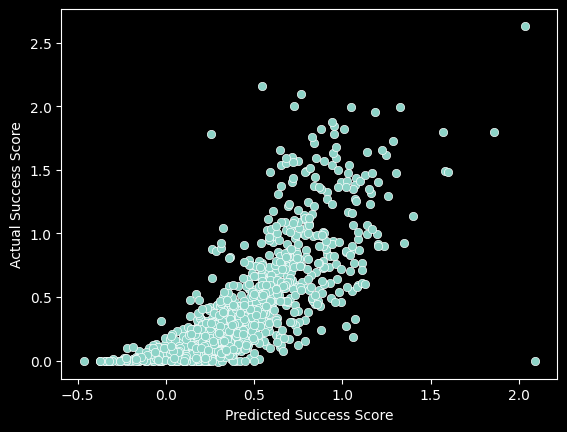

In [467]:
ax = sns.scatterplot(x=y_pred, y=y_test)
dontprintmeout = ax.set_ylabel('Actual Success Score')
dontprintmeout = ax.set_xlabel('Predicted Success Score')

In [470]:
print('correlation between predicted and actual success:', np.corrcoef(y_pred, y_test)[0][1])

correlation between predicted and actual success: 0.7730896626971052


# Building 'raw-only' model for comparison

In [472]:
raw_data_only = master_data.drop(columns=[
    'title_polarity', 
    'title_subjectivity', 
    'description_polarity',
    'description_subjectivity', 
    'neighborhood_overview_polarity',
    'neighborhood_overview_subjectivity', 
    'host_about_polarity',
    'host_about_subjectivity'
], axis=1)

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    raw_data_only.drop('success_score', axis=1), master_data['success_score'], test_size=0.2, shuffle=True, random_state=123
)

In [473]:
# Instatiate and fit a linear regressor.
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [474]:
# Predict with the model.
y_pred = model.predict(X_test)
print('MSE:', mean_squared_error(y_true=y_test, y_pred=y_pred))
print('MAE:', mean_absolute_error(y_true=y_test, y_pred=y_pred))

MSE: 0.07684950593280358
MAE: 0.1939285182603107


In [475]:
absolute_errors = abs(y_test - y_pred)
absolute_errors.describe()

count    1057.000000
mean        0.193929
std         0.198188
min         0.000023
25%         0.066976
50%         0.138314
75%         0.255842
max         2.087602
Name: success_score, dtype: float64

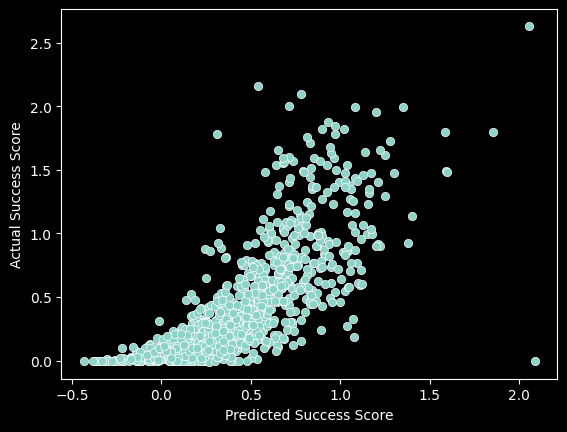

In [476]:
ax = sns.scatterplot(x=y_pred, y=y_test)
dontprintmeout = ax.set_ylabel('Actual Success Score')
dontprintmeout = ax.set_xlabel('Predicted Success Score')

In [477]:
print('correlation between predicted and actual success:', np.corrcoef(y_pred, y_test)[0][1])

correlation between predicted and actual success: 0.773180069661992


# Building 'text-inferrence-only' model for comparison

In [479]:
text_data_only = master_data[['title_polarity', 'title_subjectivity', 'description_polarity','description_subjectivity', 'neighborhood_overview_polarity','neighborhood_overview_subjectivity', 'host_about_polarity','host_about_subjectivity']]

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    text_data_only, master_data['success_score'], test_size=0.2, shuffle=True, random_state=123
)

In [480]:
# Instatiate and fit a linear regressor.
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [481]:
# Predict with the model.
y_pred = model.predict(X_test)
print('MSE:', mean_squared_error(y_true=y_test, y_pred=y_pred))
print('MAE:', mean_absolute_error(y_true=y_test, y_pred=y_pred))

MSE: 0.18333888736806622
MAE: 0.32518930042651945


In [482]:
absolute_errors = abs(y_test - y_pred)
absolute_errors.describe()

count    1057.000000
mean        0.325189
std         0.278683
min         0.002758
25%         0.148309
50%         0.271988
75%         0.408365
max         2.174494
Name: success_score, dtype: float64

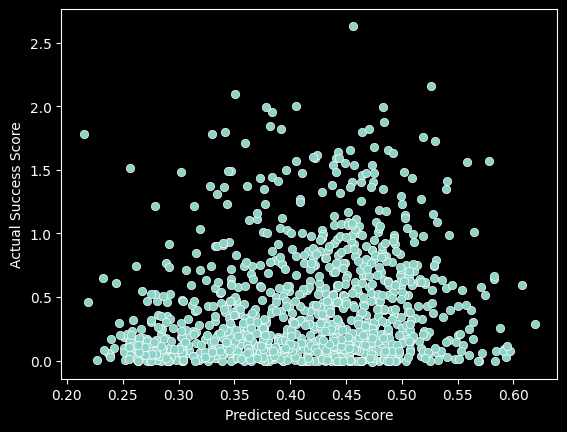

In [483]:
ax = sns.scatterplot(x=y_pred, y=y_test)
dontprintmeout = ax.set_ylabel('Actual Success Score')
dontprintmeout = ax.set_xlabel('Predicted Success Score')

In [484]:
print('correlation between predicted and actual success:', np.corrcoef(y_pred, y_test)[0][1])

correlation between predicted and actual success: 0.19862764512159856
